# Эксперименты с библиотекой DepGraph

[Ссылка](https://github.com/VainF/Torch-Pruning/) на репозиторий.

### Импорт модулей

In [1]:
!pip install torch-pruning torcheval --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from torch import nn
from torch.fx import symbolic_trace
import torch.utils.data
import torchvision
from torchvision import transforms
from torcheval.metrics import BinaryAUROC

from torchvision.models import resnet50
import torch_pruning as tp

import numpy as np
from scipy.stats import spearmanr, kendalltau

from typing import Callable, List, Tuple, Dict
from functools import reduce, partial
import re
import copy

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import networkx

sns.set_style('darkgrid')

### Реализации модулей и функций

Данные.

In [3]:
def get_dataloaders(classes: List[int], batch_size: int = 16, img_size: int = 33, need_val: bool = False, cifar100: bool = False, train_limit = None):
    classes_to_ids = {cls : i for i, cls in enumerate(classes)}
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if cifar100:
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
        
    trainset = [(x, classes_to_ids[y]) for x, y in trainset if y in classes]
    if need_val:
        _trainset = trainset[:len(trainset)//2]
        valset  = trainset[len(trainset)//2:]
        trainset = _trainset
    if train_limit:
        trainset = trainset[:train_limit]
        
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    if need_val:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True)
    if cifar100:
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    else:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    testset = [(x, classes_to_ids[y]) for x, y in testset if y in classes]
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)
    if need_val:
        return trainloader, valloader, testloader
    return trainloader, testloader

Циклы обучения и теста.

In [4]:
def train_loop(model, traindata, testdata, epoch_num=1, lr=1e-3, device='cuda'):
    history = []
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    batch_seen = 0
    
    for epoch_num in range(epoch_num):
        losses = []
        tq = tqdm(traindata, leave=False)
        
        for x, y in tq:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            
            if not isinstance(out, torch.Tensor):
                out = out[0] #  when features are also returned in forward
            
            loss = criterion(out, y)
            loss.backward()
            optim.step()
            losses.append(loss.cpu().detach().numpy())
            
            batch_seen += 1
            metric_result = test_loop(model, testdata, device)
            tq.set_description(f'Epoch: {epoch_num}, Loss: {str(np.mean(losses))}, ROC-AUC: {metric_result}')
            history.append(metric_result)
                
    return history

def test_loop(model, testdata, device='cuda', return_loss=False):
    criterion = torch.nn.CrossEntropyLoss()
    metric = BinaryAUROC(device=device)
    model.to(device)
    model.eval()
    loss = 0.0

    for x, y in testdata:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        if not isinstance(out, torch.Tensor):
            out = out[0] #  when features are also returned in forward
        pred = out.argmax(-1)
        metric.update(pred, y)
        if return_loss:
            loss += criterion(out, y).detach().cpu().item()
    
    metric_result = metric.compute().item()
    
    model.train()
    if return_loss:
        return loss
    
    return metric_result

Прунинг по примеру из репозитория DepGraph.

In [23]:
def depgraph_prune_model(
        model: torch.nn.Module,
        importance,
        prune_rate: float = 0.3,
        global_pruning: bool = False,
        example_inputs: torch.Tensor = torch.randn(1, 3, 224, 224),
        criterion = torch.nn.CrossEntropyLoss(),
        print_logs: bool = False
        ) -> torch.nn.Module:
    
    model_copy = copy.deepcopy(model)

    # 1. Initialize a pruner with the model and the importance criterion
    ignored_layers = []
    for m in model_copy.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == 2:
            ignored_layers.append(m) # DO NOT prune the final classifier!

    pruner = tp.pruner.BasePruner( # We can always choose BasePruner if sparse training is not required.
        model=model_copy,  # A to-be-pruned model
        example_inputs=example_inputs,  # dummy inputs for graph tracing
        importance=importance,  # importance estimator
        global_pruning=global_pruning,  # enable global pruning
        pruning_ratio=prune_rate,  # global channel sparisty. Also known as pruning ratio.
        ignored_layers=ignored_layers,
        round_to=8, # It's recommended to round dims/channels to 4x or 8x for acceleration. Please see: https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html
    )

    # Taylor expansion requires gradients for importance estimation
    if isinstance(importance, tp.importance.TaylorImportance):
        loss = criterion(model_copy(example_inputs), torch.zeros(1, 2))  # 0/1?
        loss.backward() # before pruner.step()

    # 2. Prune the model
    base_macs, base_nparams = tp.utils.count_ops_and_params(model_copy, example_inputs)
    pruner.step()
    macs, nparams = tp.utils.count_ops_and_params(model_copy, example_inputs)
    if print_logs:
        print(f"MACs: {base_macs/1e9} G -> {macs/1e9} G, #Params: {base_nparams/1e6} M -> {nparams/1e6} M")

    return model_copy

### Пробуем разное

Загрузим модель.

In [6]:
model = resnet50(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


Построим граф зависимости между модулями.

In [18]:
DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224))

Посмотрим на зависимости от `conv1`. Через `idxs` обозначаем каналы свёрток, которые хотим прунить.

In [9]:
group = DG.get_pruning_group(model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9])
print(group.details())


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), idxs (3) =[2, 6, 9]  (Pruning Root)
[1] prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), idxs (3) =[2, 6, 9] 
[2] prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) => prune_out_channels on _ElementWiseOp_36(ReluBackward0), idxs (3) =[2, 6, 9] 
[3] prune_out_channels on _ElementWiseOp_36(ReluBackward0) => prune_out_channels on _ElementWiseOp_35(MaxPool2DWithIndicesBackward0), idxs (3) =[2, 6, 9] 
[4] prune_out_channels on _ElementWiseOp_35(MaxPool2DWithInd

Теперь зависимость всех групп.

In [10]:
for g in DG.get_all_groups():
    print(g)


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on fc (Linear(in_features=2048, out_features=1000, bias=True)) => prune_out_channels on fc (Linear(in_features=2048, out_features=1000, bias=True)), len(idxs)=1000
--------------------------------


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)), len(idxs)=2048
[1] prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer4.0.downsample.1 (BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), len(idxs)=2048
[2] prune_out_channels on layer4.0.downsample.1 (BatchNorm2d(2048, eps=1e-05, momentum=

### Эксперименты

Скачаем данные и создадим модель.

In [6]:
trainloader, testloader = get_dataloaders([8,9], batch_size=64)

model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

100%|██████████| 170M/170M [00:03<00:00, 45.6MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Посмотрим на пример из репозитория с магнитудным прунингом. Посчитаем зависимость метрики от процента прунинга.

In [7]:
history_local = []
history_global = []

prune_rate_grid = [0.0, 0.3, 0.5, 0.7, 0.99]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate, local'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=2),
        prune_rate,
        global_pruning=False
        )
    
    history_local.append(
        train_loop(pruned_model, trainloader, testloader)
    )

for prune_rate in tqdm(prune_rate_grid, desc='prune rate, global'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=2),
        prune_rate,
        global_pruning=True
        )
    
    history_global.append(
        train_loop(pruned_model, trainloader, testloader)
    )

prune rate, local:   0%|          | 0/5 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 4.119880194 G, #Params: 23.51213 M -> 23.51213 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 1.936768242 G, #Params: 23.51213 M -> 11.205258 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 1.067659522 G, #Params: 23.51213 M -> 5.89469 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 0.345148202 G, #Params: 23.51213 M -> 2.012098 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 2.992368098 G, #Params: 23.51213 M -> 12.277202 M


  0%|          | 0/157 [00:00<?, ?it/s]

prune rate, global:   0%|          | 0/5 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 4.119880194 G, #Params: 23.51213 M -> 23.51213 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 1.709254962 G, #Params: 23.51213 M -> 13.42269 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 0.945545594 G, #Params: 23.51213 M -> 6.089842 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 0.43337521 G, #Params: 23.51213 M -> 1.634442 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 2.981567714 G, #Params: 23.51213 M -> 14.829074 M


  0%|          | 0/157 [00:00<?, ?it/s]

Построим графики.

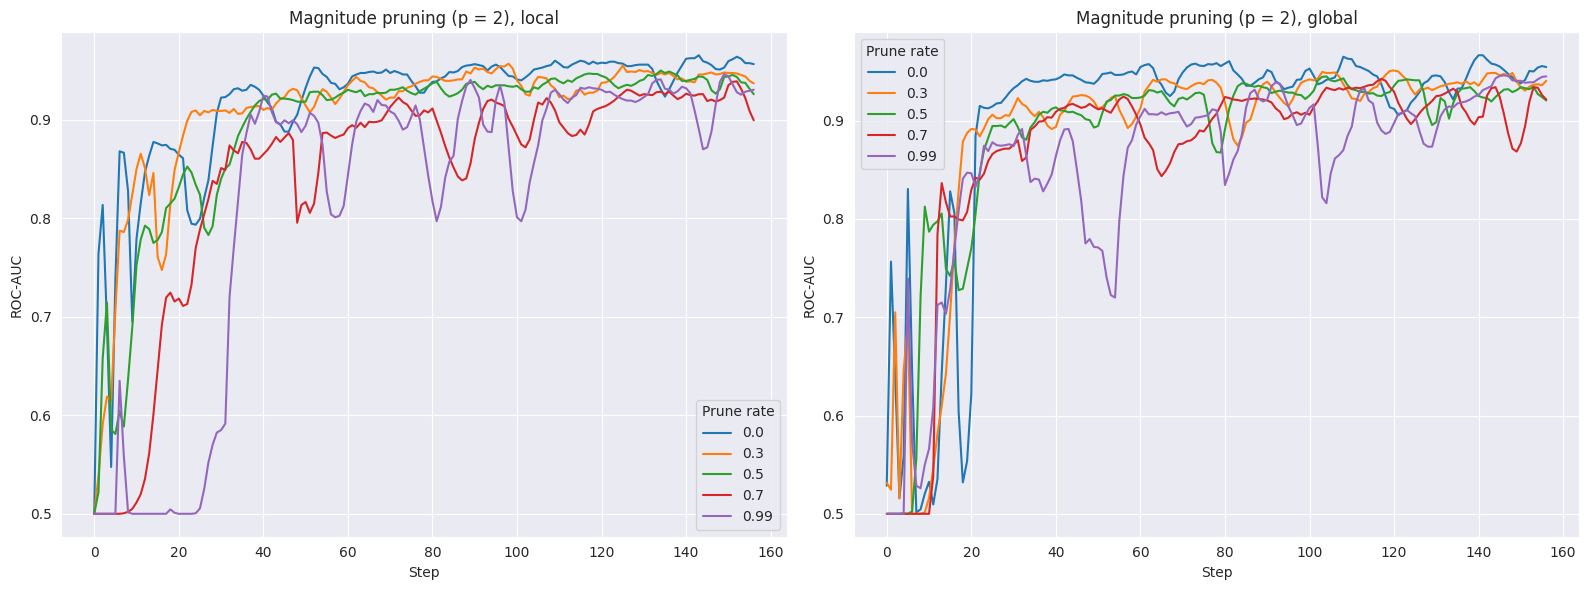

In [8]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 2), local')

plt.subplot(1, 2, 2)
for prune_rate, metric in zip(prune_rate_grid, history_global):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 2), global')

plt.tight_layout()

Давайте посмотрим на метрику до и после прунинга.

In [13]:
# Before pruning
full_model = copy.deepcopy(model)
train_loop(full_model, trainloader, testloader)
metric_result = test_loop(full_model, testloader)
print(f'Before pruning, ROC-AUC: {metric_result:.5f}')

# After pruning
prune_rate_grid = [0.1, 0.3, 0.5, 0.7, 0.99]
for prune_rate in prune_rate_grid:
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=2),
        prune_rate,
        global_pruning=False
        )
    
    metric_result = test_loop(pruned_model, testloader)
    print(f'Magnitude L2, local, rate {prune_rate}, ROC-AUC: {metric_result:.5f}')

  0%|          | 0/157 [00:00<?, ?it/s]

Before pruning, ROC-AUC: 0.93300
Magnitude L2, local, rate 0.1, ROC-AUC: 0.52300
Magnitude L2, local, rate 0.3, ROC-AUC: 0.54350
Magnitude L2, local, rate 0.5, ROC-AUC: 0.50000
Magnitude L2, local, rate 0.7, ROC-AUC: 0.58850
Magnitude L2, local, rate 0.99, ROC-AUC: 0.50000


Возьмём L1-норму.

In [ ]:
history_local = []
history_global = []

prune_rate_grid = [0.0, 0.3, 0.5, 0.7, 0.99]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate, local'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=1),
        prune_rate,
        global_pruning=False
        )
    
    history_local.append(
        train_loop(pruned_model, trainloader, testloader)
    )

for prune_rate in tqdm(prune_rate_grid, desc='prune rate, global'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=1),
        prune_rate,
        global_pruning=True
        )
    
    history_global.append(
        train_loop(pruned_model, trainloader, testloader)
    )

Построим графики.

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 1), local')

plt.subplot(1, 2, 2)
for prune_rate, metric in zip(prune_rate_grid, history_global):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 1), global')

plt.tight_layout()

Давайте посмотрим на метрику до и после прунинга.

In [14]:
# Before pruning
metric_result = test_loop(full_model, testloader)
print(f'Before pruning, ROC-AUC: {metric_result:.5f}')

# After pruning
prune_rate_grid = [0.1, 0.3, 0.5, 0.7, 0.99]
for prune_rate in prune_rate_grid:
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=1),
        prune_rate,
        global_pruning=False
        )
    
    metric_result = test_loop(pruned_model, testloader)
    print(f'Magnitude L1, local, rate {prune_rate}, ROC-AUC: {metric_result:.5f}')

Before pruning, ROC-AUC: 0.93300
Magnitude L1, local, rate 0.1, ROC-AUC: 0.53400
Magnitude L1, local, rate 0.3, ROC-AUC: 0.49950
Magnitude L1, local, rate 0.5, ROC-AUC: 0.50000
Magnitude L1, local, rate 0.7, ROC-AUC: 0.50000
Magnitude L1, local, rate 0.99, ROC-AUC: 0.50000


Теперь посмотрим на прунинг по Молчанову.

In [ ]:
history_local = []
history_global = []

prune_rate_grid = [0.0, 0.3, 0.5, 0.7, 0.99]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate, local'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.TaylorImportance(),
        prune_rate,
        global_pruning=False
        )
    
    history_local.append(
        train_loop(pruned_model, trainloader, testloader)
    )

for prune_rate in tqdm(prune_rate_grid, desc='prune rate, global'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.TaylorImportance(),
        prune_rate,
        global_pruning=True
        )
    
    history_global.append(
        train_loop(pruned_model, trainloader, testloader)
    )

Построим графики.

In [ ]:
plt.figure(figsize=(8, 6))

for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)

plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Molchanov pruning')


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Molchanov pruning, local')

plt.subplot(1, 2, 2)
for prune_rate, metric in zip(prune_rate_grid, history_global):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Molchanov pruning, global')

plt.tight_layout()

Давайте посмотрим на метрику до и после прунинга.

In [25]:
# Before pruning
metric_result = test_loop(full_model, testloader)
print(f'Before pruning, ROC-AUC: {metric_result:.5f}')

# After pruning
prune_rate_grid = [0.1, 0.3, 0.5, 0.7, 0.99]
for prune_rate in prune_rate_grid:
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.TaylorImportance(),
        prune_rate,
        global_pruning=False
        )
    
    metric_result = test_loop(pruned_model, testloader)
    print(f'Molchanov, local, rate {prune_rate}, ROC-AUC: {metric_result:.5f}')

Before pruning, ROC-AUC: 0.93300
Molchanov, local, rate 0.1, ROC-AUC: 0.50200
Molchanov, local, rate 0.3, ROC-AUC: 0.49900
Molchanov, local, rate 0.5, ROC-AUC: 0.44950
Molchanov, local, rate 0.7, ROC-AUC: 0.50000
Molchanov, local, rate 0.99, ROC-AUC: 0.49700


Пытаемся извлечь importance score.

In [33]:
DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224))

for group in DG.get_all_groups():
    print(group.items[0][0])
    print('Scores:', tp.importance.MagnitudeImportance(p=1)(group).mean(), '\n')

prune_out_channels on fc (Linear(in_features=2048, out_features=2, bias=True)) => prune_out_channels on fc (Linear(in_features=2048, out_features=2, bias=True))
Scores: tensor(1.) 

prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False))
Scores: tensor(1.0000) 

prune_out_channels on layer3.0.downsample.0 (Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer3.0.downsample.0 (Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False))
Scores: tensor(1.0000) 

prune_out_channels on layer2.0.downsample.0 (Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer2.0.downsample.0 (Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False))
Scores: tensor(1.) 

prune_out_channels on layer1.0.downsample.0 (Conv2d(64, 256, kernel_size